# Impact Classifier

The project proposes to leverage machine learning (ML) and natural language processing (NLP) techniques to build a text classifier that automatizes the processing and identification of evidence of social impact in research documents. The proposal aims to solve a classification problem in which the model takes a sentence contained in a research document as input and produces as output a binary answer (1=True, 0=False) that states whether the sentence contains or not evidence of social impact, respectively.

From all research fields, this project focuses on Medical, Health, and Biological science because the ultimately goal is to understand the social impact of the research projects of the Spanish National Institue of Bioinformatics (INB by its Spanish Acronym), which is an institution that conducts medical and biological investigations.

The goal of this notebook is to develop a machine learning classifier able to automatically identify sentences of social impact in research documents.

## Load libraries

In [2]:
import glob
import numpy as np
import nltk
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import sys
import joblib
import json
import pickle
import seaborn as sns


nltk.download("stopwords")
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from bs4 import BeautifulSoup
from data_processor import *
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from utils import save_model

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/Life/jsaldiva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/Life/jsaldiva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/Life/jsaldiva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/Life/jsaldiva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load data

### Impact sentences

Load summaries with sentences with evidence of social impact. The data were extracted from the impact case studies published by REF (Research Excellence Framework) and it contains the summary of societal impact of Medical, Health, and Biological research. Summaries can be access [here](https://impact.ref.ac.uk/casestudies/Results.aspx?Type=I&Tag=5085).

In [2]:
ref_impact = pd.read_csv('data/source/social_impact_ref_bio_medicine.csv', usecols=['Summary of the impact'])

#### Split summaries into sentences

In [3]:
impact_sentences = pd.DataFrame(columns=['sentence'])
for i in ref_impact.index:
    sentences = sent_tokenize(ref_impact.loc[i, 'Summary of the impact'])
    for sentence in sentences:
        impact_sentences = impact_sentences.append({'sentence': sentence}, ignore_index=True)        

#### Clean sentences

In [4]:
%%time
impact_sentences['sentence'] = impact_sentences['sentence'].apply(lambda x: clean_sentence(x))

CPU times: user 289 ms, sys: 16.1 ms, total: 305 ms
Wall time: 298 ms


#### Add label column

Sentences with evidence of social will later be merged with more general sentences that can be commonly found in research documents. By the time the merge occurs, social impact sentences need to be distinguised from the more general sentences. Therefore, a the new column **`label`** is created in the impact dataset to tag with 1 all sentences that contain evidence of social impact.  

In [5]:
impact_sentences['label'] = 1

In [6]:
nrows = impact_sentences.shape[0]
ncols = impact_sentences.shape[1]
print(f"The dataset contains {nrows} rows and {ncols} columns")

The dataset contains 2373 rows and 2 columns


Let's show an sample of impact sentences together with the newly created column label.

In [7]:
impact_sentences.head()

,sentence,label
0,The Guide to Receptors and Channels has contri...,1
1,The key tools it provides have influenced appr...,1
2,It is used widely as a teaching aid for underg...,1
3,It led to the formation of the Guide to Pharma...,1
4,The Cardiff Osteological Research Group CORG h...,1


### General sentences

Load dataset containing sentences that are commonly found in medical and bioinformatics research documents. The process followed to build the dataset of general sentences is described in the section *Collection of medical and biological sentences* of the notebook **`0.dataset_preparation.ipynb`**.

In [8]:
gral_sentences = pd.read_csv("data/sentences/gral_sentences_3000.csv", index_col=0)

#### Clean sentences

In [9]:
gral_sentences['sentence'] = gral_sentences['sentence'].apply(lambda x: clean_sentence(x))

#### Add label column

As in the case of the dataset of impact sentences, here a column **`label`** is also created to tag with 0 all general sentences.

In [10]:
gral_sentences['label'] = 0

In [11]:
nrows = gral_sentences.shape[0]
ncols = gral_sentences.shape[1]
print(f"The dataset contains {nrows} rows and {ncols} columns")

The dataset contains 3000 rows and 2 columns


Let's show a sample of the dateset

In [12]:
gral_sentences.head()

,sentence,label
0,Tumor and patient characteristics are summariz...,0
1,The execution run for days to complete and the...,0
2,Actually a recent study indicated that over ex...,0
3,The motivation is we need to address the compo...,0
4,However based on measurements of estradiol lev...,0


### Merge datasets

Merge both datasets, the general and impact one.

In [13]:
total_sentences = pd.concat([impact_sentences, gral_sentences], ignore_index=True)

In [14]:
nrows = total_sentences.shape[0]
ncols = total_sentences.shape[1]
print(f"The combined dataset contains {nrows} rows and {ncols} columns")

The combined dataset contains 5373 rows and 2 columns


## Explore data

Next, the dataset is explored by, first, computing the most frequent terms in sentences that contain evidence of social impact and, then, by calculating the most frequent term in general sentences.

In [23]:
word_black_list = ['research', 'uk']  # let's add context specify words that will be filtered before computing frequencies
max_items_to_show = 30

### Most frequent terms in social impact sentences

Inspect the most used terms used in sentences that express evidence of social impact

In [24]:
si_sentences = total_sentences[total_sentences['label']==1]['sentence']
si_words = []
for si_sentence in si_sentences:
    for word in si_sentence.split():
        if len(word) > 2 and word not in word_black_list and word not in stopwords.words('english'):
            si_words.append(word)
fdist = FreqDist(si_words)
freq_words_df = pd.DataFrame(fdist.items(), columns=['word', 'frequency'])

In [25]:
freq_words_df.sort_values(by='frequency', ascending=False, inplace=True)

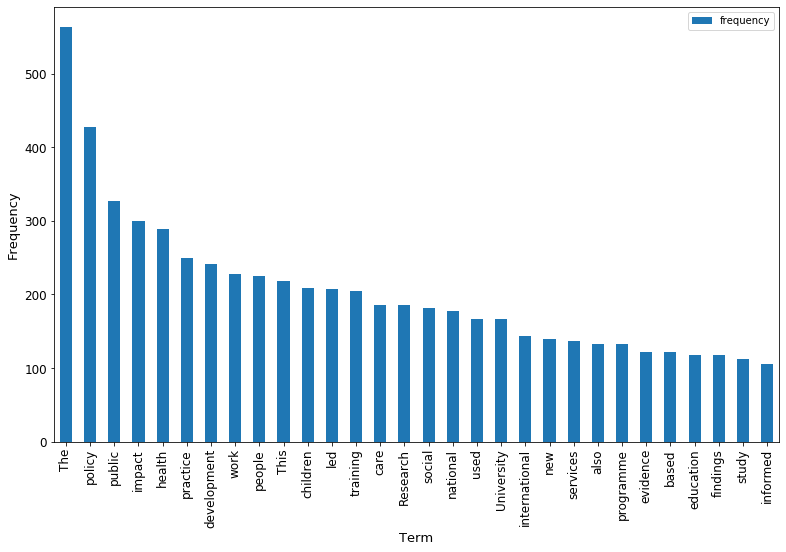

In [26]:
freq_words_df.iloc[0:max_items_to_show,:].plot(x='word', y='frequency', kind='bar', figsize=(13,8))
plt.xticks(rotation=90)
plt.xlabel("Term", size=13)
plt.ylabel("Frequency", size=13)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

### Most frequent terms in general sentences

Inspect the most used terms in sentences that do not neccesarily contain evidence of social impact

In [27]:
n_si_sentences = total_sentences[total_sentences['label']==0]['sentence']
n_fdist = FreqDist(word for n_si_sentence in n_si_sentences 
                        for word in n_si_sentence.split() if len(word) > 2 and word not in stopwords.words('english') and word not in word_black_list)
n_freq_words_df = pd.DataFrame(n_fdist.items(), columns=['word', 'frequency'])

In [28]:
n_freq_words_df.sort_values(by='frequency', ascending=False, inplace=True)

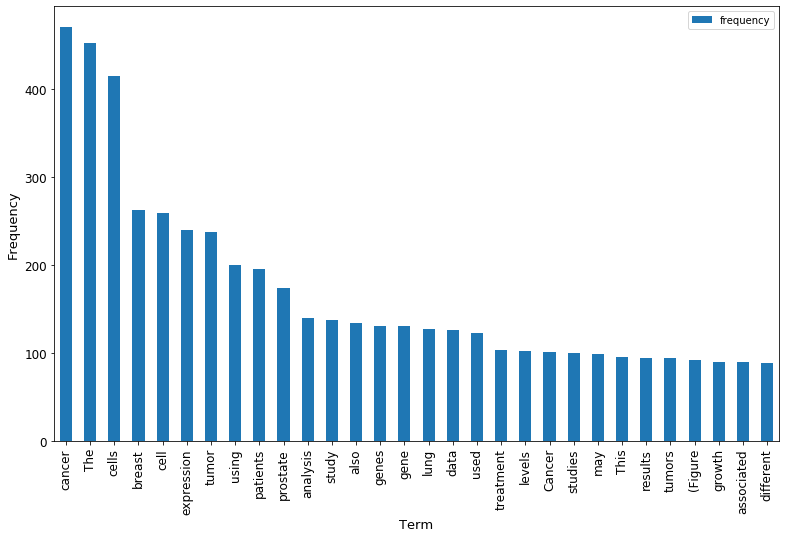

In [29]:
n_freq_words_df.iloc[0:max_items_to_show,:].plot(x='word', y='frequency', kind='bar', figsize=(13,8))
plt.xticks(rotation=90)
plt.xlabel("Term", size=13)
plt.ylabel("Frequency", size=13)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

From the figures above it can be seen there is little overlap between the most frequent terms in sentences with evidence of social impact (e.g., public policy, health, national, development) and the most frequent terms in the general sentences, which, as expected, are more related with medical and biological terminologies, such as cancer, cells, patients, tumor, or therapy. The low interception between the most frequent terms in the two datasets demonstrates the potential of the data to train machine learning classifier. 

## Augment data with additional text-based features

Augment data of sentences with the following text-based extra features:
1. **Word count of sentences**: total number of words in sentences
2. **Character count of sentences**: total number of characters in sentences
3. **Average word density of sentences**: average length of words in sentences
4. **Upper case count in sentences**: total number of upper count words in sentences
5. **Title word count in sentences**: total number of title case words in sentences

In [15]:
total_sentences['char_count'] = total_sentences['sentence'].apply(len)
total_sentences['word_count'] = total_sentences['sentence'].apply(lambda x: len(x.split()))
total_sentences['word_density'] = total_sentences['char_count'] / (total_sentences['word_count']+1)
total_sentences['upper_case_word_count'] = total_sentences['sentence'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
total_sentences['title_word_count'] = total_sentences['sentence'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))

Also, we add frequency distribution of part-of-speech tags

In [16]:
%%time
total_sentences['noun_count'] = total_sentences['sentence'].apply(lambda x: count_pos_tag(x, 'noun'))
total_sentences['verb_count'] = total_sentences['sentence'].apply(lambda x: count_pos_tag(x, 'verb'))
total_sentences['adj_count'] = total_sentences['sentence'].apply(lambda x: count_pos_tag(x, 'adj'))
total_sentences['adv_count'] = total_sentences['sentence'].apply(lambda x: count_pos_tag(x, 'adv'))
total_sentences['pron_count'] = total_sentences['sentence'].apply(lambda x: count_pos_tag(x, 'pron'))

CPU times: user 46.8 s, sys: 369 ms, total: 47.1 s
Wall time: 47.1 s


In [17]:
total_sentences.head()

,sentence,label,char_count,word_count,word_density,upper_case_word_count,title_word_count,noun_count,verb_count,adj_count,adv_count,pron_count
0,The Guide to Receptors and Channels has contri...,1,137,19,6.850000,0,4,7,2,1,0,0
1,The key tools it provides have influenced appr...,1,215,34,6.142857,0,3,9,7,4,0,0
2,It is used widely as a teaching aid for underg...,1,167,25,6.423077,0,1,10,3,2,1,0
3,It led to the formation of the Guide to Pharma...,1,141,22,6.130435,0,8,10,1,0,0,0
4,The Cardiff Osteological Research Group CORG h...,1,144,20,6.857143,1,7,10,2,1,0,0


## Augment data with sentiment analysis

Include sentiment score of sentences as an additional feature. Sentences with evidence of social impact are expected to have a more positive attitude than general sentences.

In [18]:
total_sentences['sentiment_score'] = total_sentences['sentence'].apply(lambda x: analyze_sentiment(x))

In [19]:
total_sentences.head()

,sentence,label,char_count,word_count,word_density,upper_case_word_count,title_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,sentiment_score
0,The Guide to Receptors and Channels has contri...,1,137,19,6.850000,0,4,7,2,1,0,0,0.5106
1,The key tools it provides have influenced appr...,1,215,34,6.142857,0,3,9,7,4,0,0,0.8481
2,It is used widely as a teaching aid for underg...,1,167,25,6.423077,0,1,10,3,2,1,0,0.0000
3,It led to the formation of the Guide to Pharma...,1,141,22,6.130435,0,8,10,1,0,0,0,0.0000
4,The Cardiff Osteological Research Group CORG h...,1,144,20,6.857143,1,7,10,2,1,0,0,0.0000


Print out mean sentiment scores of both sentences with evidence of social impact (1) and general sentences (0).

In [20]:
total_sentences.groupby(['label'])['sentiment_score'].mean()

label
0   -0.059345
1    0.215310
Name: sentiment_score, dtype: float64

## Prepare sentences

Data will be prepared using the following combinations of the text processing tasks defined in `sentence_to_words`:
1. Sentence is tokenized and stop words as well as HTML elements are removed. Stemming is also applied;
2. Sentence is tokenized, stop words and HTML elements are removed and stemming and lemmatization are applied.


In [21]:
text, extra_features, labels = total_sentences['sentence'], total_sentences.iloc[:,2:], total_sentences['label']

In [22]:
context_words = ['reseach', 'uk']

In [23]:
%%time
text_clean = [sentence_to_words(sentence, context_words) for sentence in text]
text_clean_with_lemmatization = [sentence_to_words(sentence, context_words, lemmatization=True) for sentence in text]

CPU times: user 12.4 s, sys: 466 ms, total: 12.8 s
Wall time: 12.8 s


Save preprocess text into a dictionary to avoid carrying around the recently create variables

In [24]:
preprocess_text = {
    'clean': {'text': text_clean, 'labels': labels, 'extra_features': extra_features},
    'clean_lemmatization': {'text': text_clean_with_lemmatization, 'labels': labels, 'extra_features': extra_features}
}

Check a sample of the preprocess data

In [25]:
preprocess_text['clean']['text'][0]

['guid',
 'receptor',
 'channel',
 'contribut',
 'develop',
 'mainten',
 'intellectu',
 'infrastructur',
 'pharmacolog']

### Transform to Bag-of-Words Representation

Previously processed sentences are transformed here to a bag-of-words representation.

Define transformation conditions

In [52]:
transformations = ['tc', 'tfidf']
max_features=[500, 800, 1000, 2000, 5000, 10000]
ngram_ranges=[(1,1),(1,2),(1,3)]
total_cycles = len(transformations)*len(max_features)*len(ngram_ranges)*len(preprocess_text)

In [53]:
transformed_txts = []

In [54]:
with tqdm(total=total_cycles, file=sys.stdout) as pbar:
    for transformation in transformations:        
        for max_feature in max_features:
            for ngram_range in ngram_ranges:
                for processing_task, data_dict in preprocess_text.items():
                    pbar.update(1)
                    text = data_dict['text']
                    transformed_data, vocabulary = extract_BoW_features(text, max_feature, transformation, ngram_range)
                    transformed_txts.append(
                        {
                            'transformation': transformation,
                            'max_features': max_feature,
                            'ngram_range': ngram_range,
                            'data': transformed_data,
                            'processing_task': processing_task,
                            'labels': data_dict['labels'],
                            'vocabulary': vocabulary,
                            'extra_features': data_dict['extra_features']
                        }
                    )

100%|██████████| 72/72 [00:53<00:00,  1.34it/s]


Let's do some sanity check

In [55]:
transformed_txts[0]

{'transformation': 'tc',
 'max_features': 500,
 'ngram_range': (1, 1),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'processing_task': 'clean',
 'labels': 0       1
 1       1
 2       1
 3       1
 4       1
        ..
 5368    0
 5369    0
 5370    0
 5371    0
 5372    0
 Name: label, Length: 5373, dtype: int64,
 'vocabulary': {'receptor': 367,
  'contribut': 94,
  'develop': 119,
  'key': 229,
  'tool': 461,
  'provid': 354,
  'influenc': 214,
  'lead': 235,
  'drug': 133,
  'target': 449,
  'studi': 438,
  'result': 385,
  'receiv': 365,
  'support': 445,
  'industri': 213,
  'use': 480,
  'wide': 491,
  'aid': 16,
  'research': 380,
  'gener': 178,
  'public': 357,
  'inform': 215,
  'led': 237,
  'collabor': 79,
  'intern': 223,
  'clinic': 75,
  'group': 184,
  'complex': 86,
  'relationship': 376,
  'an

In [56]:
assert len(transformed_txts[0]['data']) == len(transformed_txts[0]['labels'])

## Split data into train and test and save it

Iterate over the 180 combinations of text processings and transformations and for each combination hold out a fraction of data for testing the model and save the rest for training the model.

In [19]:
random_state = np.random.RandomState(1234)  # set a random seed for reproducibility purposes

In [58]:
with tqdm(total=total_cycles, file=sys.stdout) as pbar:
    for transformed_txt in transformed_txts:
        transformation = transformed_txt['transformation']
        max_features = str(transformed_txt['max_features'])
        ngram_range = str(transformed_txt['ngram_range'])
        processing_task = transformed_txt['processing_task']
        vocabulary = transformed_txt['vocabulary']
        data = pd.DataFrame({'sentence': list(transformed_txt['data']), 'label': transformed_txt['labels']})
        data = pd.concat([data, transformed_txt['extra_features']], axis=1)
        # select 20% of each class for testing
        test_label_1 = data[data['label']==1].sample(frac=0.2, random_state=random_state)
        test_label_0 = data[data['label']==0].sample(frac=0.2, random_state=random_state)        
        test_data = pd.concat([test_label_1, test_label_0], ignore_index=True)
        # take the rest for training
        test_indexes = list(test_label_1.index) + list(test_label_0.index)
        train_data = data[~data.index.isin(test_indexes)]
        # check if the number of rows in train and test are equal to the number of rows in data
        assert (train_data.shape[0]+test_data.shape[0]) == data.shape[0], 'Number of rows in train and test datasets should be equal to the numeber of rows in the entire dataset'
        # save data
        data = None
        data_filename = f'data_{transformation}_{max_features}_{ngram_range}_{processing_task}.pkl'
        dict_data = dict(train_data=train_data, test_data=test_data, vocabulary=vocabulary, 
                         transformation=transformation, max_features=max_features, ngram_range=ngram_range,
                         processing_task=processing_task)
        with open(os.path.join('data', 'train_test', data_filename), "wb") as f:
            joblib.dump(dict_data, f)    
        pbar.update(1)

100%|██████████| 72/72 [03:04<00:00,  2.56s/it]


## Build ML model

Here we build the machine learning classifier. The decision on the algorithms to be used was based on algorithms that have been reported to perform well on unbalanced, small, and textual datasets, which is our case. Therefore, we try the following algorithms: Naive-Bayes, Support Vector Machine, Logistic Regression, Random Forest, and Gradient Boosting.

In bulding the model we proceed as following:
1. Compare the performance of the choosen algorithms by training them in each of the 180 different training sets;
2. Choose the best performing model for each algorithm;
3. Perform hyper-parameters optimization for the best models, except Naive-Bayes. GridSearch is used for SVM and Logistic Regression while RandomGridSearch with 100 iterations is employed for Random Forest and Gradient Boosting;
4. Plot learning curves for the best models to analyze the overfitting effect on the training set and the effect of the training size on the performance metric;
5. Select the model that best generalize the prediction.

Models are trained using the cross-validation approach. The performance metric to be optimized is **`recall`** because, in spite of over-identifying sentences that might not contain evidence of social impact and even when more sentences mean an overload of work for evaluators, the aim is to avoid losing sentences that can potentially contain evidence of impact and thus might be deciding in understanding the social impact of the research.

In [17]:
def get_classifier(algorithm_name):
    if algorithm_name == 'NB':
        classifier = GaussianNB()
    elif algorithm_name == 'SVM':
        classifier = SVC(random_state=random_state)   
    elif algorithm_name == 'LR':
        classifier = LogisticRegression(random_state=random_state)
    elif algorithm_name == 'RF':        
        classifier = RandomForestClassifier(random_state=random_state)
    elif algorithm_name == 'GB':
        classifier = GradientBoostingClassifier(random_state=random_state)
    else:
        print("Unknown algorithm: {0}",format(algorithm_name))
    return classifier

In [27]:
num_splits = 3
kfold = KFold(n_splits=num_splits, shuffle=True, random_state=42)
algorithms = ['NB', 'SVM', 'LR', 'RF', 'GB']

In [15]:
total_cycles *= len(algorithms)

In [20]:
outputs = []
with tqdm(total=total_cycles, file=sys.stdout) as pbar:
    data_path = os.path.join('data', 'train_test', '*.pkl')
    files = glob.glob(data_path)            
    for file in files:
        with open(file, "rb") as f:
            data = joblib.load(f)
        train_data = data['train_data']
        y_train = train_data['label'].values
        text_features = list(train_data.iloc[:,0].values)        
        extra_features = np.array(train_data.iloc[:,2:].values)
        X_train = np.concatenate((text_features, extra_features), axis=1)
        for algorithm in algorithms:            
            classifier = get_classifier(algorithm)                
            scores = cross_val_score(classifier, X_train, y=y_train, scoring="balanced_accuracy", cv=kfold, n_jobs=3)
            outputs.append(
                {
                    'algorithm': algorithm,
                    'train_filename': file,                
                    'metric_scores': scores,
                }
            )   
            pbar.update(1)

73it [1:29:17, 73.39s/it]                         


In [21]:
output_df = pd.DataFrame(columns=['algorithm', 'train_data_file', 'mean_balanced_accuracy'])
for output in outputs:
    row = {
        'algorithm': output['algorithm'],
        'train_data_file': output['train_filename'],
        'mean_balanced_accuracy': round(output['metric_scores'].mean(), 2),
        'std_balanced_accuracy': round(output['metric_scores'].std(), 2)
    }
    output_df = output_df.append(row, ignore_index=True)

In [18]:
output_df.head()

,algorithm,train_data_file,mean_balanced_accuracy,std_balanced_accuracy
0,NB,"data/train_test/data_tfidf_10000_(1, 1)_clean_...",0.95,0.01
1,LR,"data/train_test/data_tfidf_10000_(1, 1)_clean_...",0.93,0.01
2,RF,"data/train_test/data_tfidf_10000_(1, 1)_clean_...",0.92,0.01
3,GB,"data/train_test/data_tfidf_10000_(1, 1)_clean_...",0.91,0.01
4,NB,"data/train_test/data_tfidf_1000_(1, 1)_clean_l...",0.95,0.00


Save training results to a csv

In [19]:
experiment_dir = 'experiments'  # directory to store experiments
os.makedirs(experiment_dir, exist_ok=True)  # ensure the directory exists
output_df.to_csv(experiment_dir+'/e_03062020.csv', index=False)

### Compare the best models of each type

In [28]:
mean_best_models, std_best_models = [], []
for algorithm in algorithms:
    best_model = output_df[output_df['algorithm']==algorithm].sort_values(by=['mean_balanced_accuracy', 'std_balanced_accuracy'], ascending=False).head(1)
    mean_recall = best_model['mean_balanced_accuracy'].values[0]
    std_recall = best_model['std_balanced_accuracy'].values[0]
    mean_best_models.append(mean_recall)    
    std_best_models.append(std_recall)
    data_fn = best_model['train_data_file'].values[0]    
    print(f'Algorithm: {algorithm}, Mean: {mean_recall}, Std.: {std_recall}, Train Data File: {data_fn}')

Algorithm: NB, Mean: 0.97, Std.: 0.01, Train Data File: data/train_test/data_tfidf_10000_(1, 2)_clean_lemmatization.pkl
Algorithm: SVM, Mean: 0.63, Std.: 0.02, Train Data File: data/train_test/data_tfidf_5000_(1, 1)_clean.pkl
Algorithm: LR, Mean: 0.96, Std.: 0.01, Train Data File: data/train_test/data_tc_5000_(1, 1)_clean.pkl
Algorithm: RF, Mean: 0.94, Std.: 0.01, Train Data File: data/train_test/data_tfidf_10000_(1, 1)_clean.pkl
Algorithm: GB, Mean: 0.92, Std.: 0.01, Train Data File: data/train_test/data_tfidf_10000_(1, 3)_clean_lemmatization.pkl


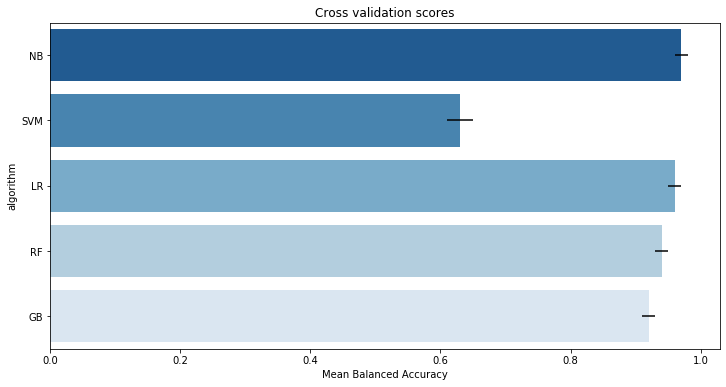

In [29]:
cv_res = pd.DataFrame({
    'cross_val_means': mean_best_models,
    'cross_val_std': std_best_models,
    'algorithm': algorithms
})
plt.figure(figsize=(12,6))
g = sns.barplot('cross_val_means', 'algorithm', data = cv_res, palette='Blues_r', orient = "h", **{'xerr':std_best_models})
g.set_xlabel('Mean Balanced Accuracy')
g = g.set_title('Cross validation scores')

### Perform hyper-parameters optimization

**Hyperparametrization processes have been run outside the notebook through the script `train.py`**

### Plot learning curve

In [7]:
# Taken from 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), shuffle=False):
    """Generate a simple plot of the test and training learning curve"""
    
    plt.figure(figsize=(12,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, n_jobs=n_jobs, cv=cv, train_sizes=train_sizes, shuffle=shuffle)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#### **Naive-Bayes (NB)**

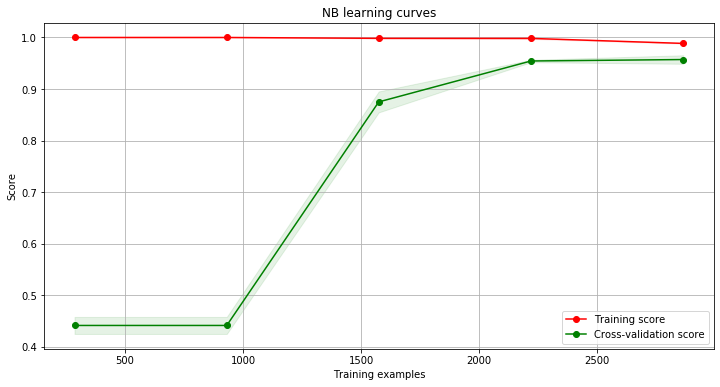

In [11]:
best_model = output_df[output_df['algorithm']=='NB'].sort_values(by=['mean_balanced_accuracy', 'std_balanced_accuracy'], ascending=False).head(1)
with open(best_model['train_data_file'].values[0], "rb") as f:
    data = joblib.load(f)
train_data = data['train_data']
X_train_nb = list(train_data['sentence'].values)
y_train_nb = train_data['label'].values
g = plot_learning_curve(GaussianNB(), "NB learning curves", X_train_nb, y_train_nb, cv=kfold)
g.show()

**Diagnosis**. Scores in the learning curve of the NB model vary little as the size of the training set increases. This indicates that the model might overfit on the training data (high variance). On the other hand, the validation curve increases as more training examples are available, which tells us that the model is correctly learning from the training examples. The small gap between training and validation is a sign of low variance.

#### **Support Vector Machine (SVM)**

In [30]:
# get data
best_model = output_df[output_df['algorithm']=='SVM'].sort_values(by=['mean_balanced_accuracy', 'std_balanced_accuracy'], ascending=False).head(1)
with open(best_model['train_data_file'].values[0], "rb") as f:
    data = joblib.load(f)
train_data = data['train_data']
y_train_svm = train_data['label'].values
text_features = list(train_data.iloc[:,0].values)        
extra_features = np.array(train_data.iloc[:,2:].values)
X_train_svm = np.concatenate((text_features, extra_features), axis=1)

In [3]:
svm_best = joblib.load('./models/best_support_vector_machine-tfidf_5000_(1, 1)_clean.joblib')

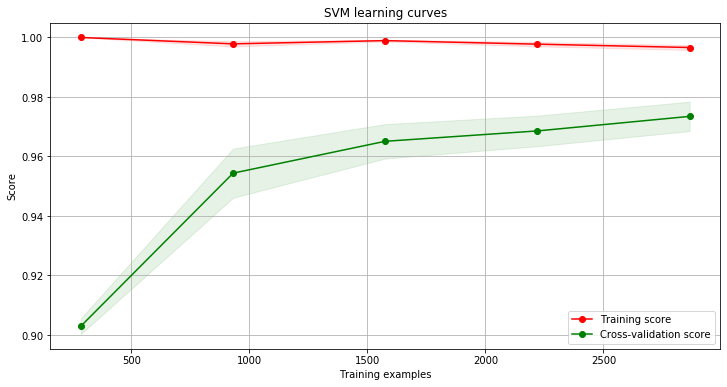

In [32]:
g = plot_learning_curve(svm_best, "SVM learning curves", X_train_svm, y_train_svm, cv=kfold, shuffle=True)
g.show()

**Diagnosis**. Scores in the learning curve of the SVM model slightly decrease as the number of training examples increases. This might indicate that the model does not overfitting on training data (low variance). On the contrary, the validation curve increases as more training examples are available, which tells us that the model is correctly learning from the training examples. It seems that with more data curves will converge at some point.

#### **Logistic Regression (LR)**

In [5]:
# get data
best_model = output_df[output_df['algorithm']=='LR'].sort_values(by=['mean_balanced_accuracy', 'std_balanced_accuracy'], ascending=False).head(1)
with open(best_model['train_data_file'].values[0], "rb") as f:
    data = joblib.load(f)
train_data = data['train_data']
y_train_lr = train_data['label'].values
text_features = list(train_data.iloc[:,0].values)        
extra_features = np.array(train_data.iloc[:,2:].values)
X_train_lr = np.concatenate((text_features, extra_features), axis=1)

In [4]:
lr_best = joblib.load('./models/best_logistic_regression-tc_5000_(1, 1)_clean.joblib')

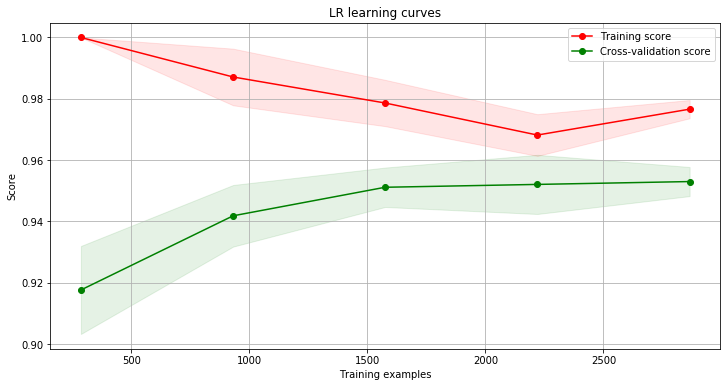

In [8]:
g = plot_learning_curve(lr_best, "LR learning curves", X_train_lr, y_train_lr, cv=kfold, shuffle=True)
g.show()

**Diagnosis**. Scores in the learning curve of the SVM model decrease as the number of training examples increases. This indicate that the model does not overfitting on training data (low variance). On the contrary, the validation curve increases as more training examples are available, which tells us that the model is correctly learning from the training examples.

#### **Random Forest (RF)**

In [9]:
# get data
best_model = output_df[output_df['algorithm']=='RF'].sort_values(by=['mean_balanced_accuracy', 'std_balanced_accuracy'], ascending=False).head(1)
with open(best_model['train_data_file'].values[0], "rb") as f:
    data = joblib.load(f)
train_data = data['train_data']
y_train_rf = train_data['label'].values
text_features = list(train_data.iloc[:,0].values)        
extra_features = np.array(train_data.iloc[:,2:].values)
X_train_rf = np.concatenate((text_features, extra_features), axis=1)

In [5]:
rf_best = joblib.load('./models/best_random_forest-tfidf_10000_(1, 1)_clean.joblib')

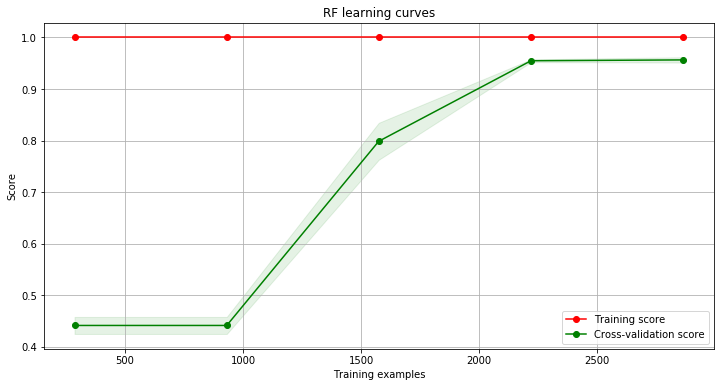

In [11]:
g = plot_learning_curve(rf_best, "RF learning curves", X_train_rf, y_train_rf, cv=kfold)
g.show()

**Diagnosis**. In this model the training score is at maximum regardless of the training size, which is signal of overfitting.

#### **Gradient Boosting (GB)**

In [12]:
# get train data
best_model = output_df[output_df['algorithm']=='GB'].sort_values(by=['mean_balanced_accuracy', 'std_balanced_accuracy'], ascending=False).head(1)
with open(best_model['train_data_file'].values[0], "rb") as f:
    data = joblib.load(f)
train_data = data['train_data']
y_train_gb = train_data['label'].values
text_features = list(train_data.iloc[:,0].values)        
extra_features = np.array(train_data.iloc[:,2:].values)
X_train_gb = np.concatenate((text_features, extra_features), axis=1)

In [6]:
gb_best = joblib.load('./models/best_gradient_boosting-tfidf_10000_(1, 3)_clean_lemmatization.joblib')

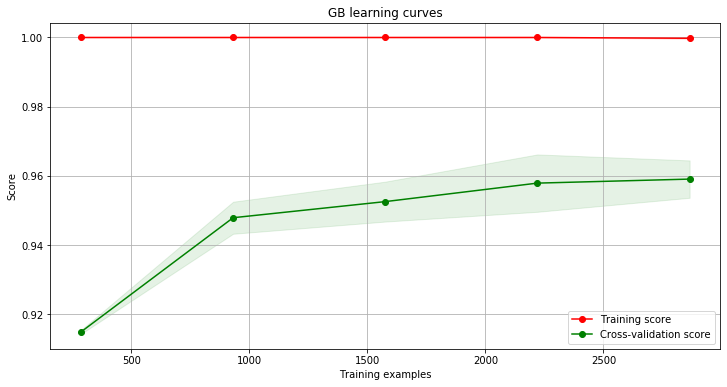

In [17]:
g = plot_learning_curve(gb_best, "GB learning curves", X_train_gb, y_train_gb, cv=kfold, shuffle=True)
g.show()

**Diagnosis**. In this model the training score is at maximum regardless of the training size, which is signal of overfitting. The large gap between training and validation confirms a high-variance scenario.

### Select model

Based on the previous diagnosis, a Support Vector Machine model is selected as the best option to conduct the classification task.

#### Save Model

In [5]:
train_fn = output_df[output_df['algorithm']=='SVM'].sort_values(by=['mean_balanced_accuracy', 'std_balanced_accuracy'], ascending=False).head(1)['train_data_file'].values[0]
save_model(svm_best, 'support-vector-machine', 'SVM', 'balanced_accuracy', train_fn)

## Evaluate model

### Load model

In [7]:
model_dict = joblib.load('./models/support-vector-machine.joblib')
model = model_dict['model']

### Load test data

In [11]:
data_fn = model_dict['data_fn']
with open(os.path.join('data','train_test',data_fn), 'rb') as f:
    data = joblib.load(f)
test_data = data['test_data']
y_test = test_data['label'].values
text_features = list(test_data.iloc[:,0].values)        
extra_features = np.array(test_data.iloc[:,2:].values)
X_test = np.concatenate((text_features, extra_features), axis=1)

### Make predictions

In [12]:
pred = model.predict(X_test)

### Compute performance metrics

In [13]:
print(f'Balanced Accuracy: {round(metrics.recall_score(y_test, pred),2)}')

Balanced Accuracy: 0.94


In [3]:
s = 'RD-CONNECT Report Summary Project ID: 305444 Funded under: FP7-HEALTH Country: United Kingdom Periodic Report Summary 5 - RD-CONNECT (RD-CONNECT: An integrated platform connecting registries, biobanks and clinical bioinformatics for rare disease research) Project Context and Objectives: RD-Connect is a global research and infrastructure resource for rare diseases (RD).'

In [5]:
sentence_words = sentence_to_words(s)
sentence_words

['rd',
 'connect',
 'report',
 'summary',
 'project',
 'id',
 'funded',
 'fp',
 'health',
 'country',
 'united',
 'kingdom',
 'periodic',
 'report',
 'summary',
 'rd',
 'connect',
 'rd',
 'connect',
 'integrated',
 'platform',
 'connecting',
 'registries',
 'biobanks',
 'clinical',
 'bioinformatics',
 'rare',
 'disease',
 'research',
 'project',
 'context',
 'objectives',
 'rd',
 'connect',
 'global',
 'research',
 'infrastructure',
 'resource',
 'rare',
 'diseases',
 'rd']

In [10]:
with open('./data/train_test/data_tc_800_(1, 3)_clean.pkl', 'rb') as f:
        data = joblib.load(f)

In [14]:
vectorizer = CountVectorizer(max_features=800, ngram_range=(1, 3),
                             vocabulary=data['vocabulary'],
                             preprocessor=lambda x: x, tokenizer=lambda x: x,
                             lowercase=False)

In [31]:
data['vocabulary']
x = {k:v for k, v in sorted(data['vocabulary'].items(), key=lambda x: x[1])}

In [17]:
bag_of_words = vectorizer.transform([sentence_words]).toarray()

In [29]:
bag_of_words[bag_of_words!=0]

array([1, 1, 1, 1, 2, 2, 1])

In [27]:
np.where(bag_of_words!=0)[1]

array([134, 150, 204, 303, 604, 608, 755])

In [30]:
idxs = np.where(bag_of_words!=0)[1]
for k, v in x.items():
    if v in idxs:
        print(k)

clinical
context
disease
health
report
research
united


In [9]:
model.predict(bag_of_words)

array([1])